<a href="https://colab.research.google.com/github/maxmatical/gld_forecasting/blob/master/GLD_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install git+https://github.com/fastai/fastai.git
!pip install scikit-optimize
!install pyro-ppl 
!pip install --upgrade ta

In [2]:
!git clone https://github.com/maxmatical/gld_forecasting.git


Cloning into 'gld_forecasting'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [1]:
%cd /content/gld_forecasting
!ls

/content/gld_forecasting
GLD.csv  GLD_Forecasting.ipynb	lookahead.py  radam.py	ranger.py  README.md


In [0]:
# Set up environment and download course-v3
# !curl -s https://course.fast.ai/setup/colab | bash

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import ta
from fastai import *
from fastai.tabular import * 
from fastai.utils.show_install import *
from fastai.callbacks import *
show_install()




```text
=== Software === 
python        : 3.6.9
fastai        : 1.0.61.dev0
fastprogress  : 0.2.2
torch         : 1.3.1
nvidia driver : 418.67
torch cuda    : 10.1.243 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 15079MB | Tesla T4

=== Environment === 
platform      : Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Thu Aug 8 02:47:02 PDT 2019
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-ru

In [3]:
df = pd.read_csv('./GLD.csv')
df.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume
3814,2020-01-15,146.210007,146.729996,145.820007,146.539993,146.539993,6510000
3815,2020-01-16,146.270004,146.470001,145.759995,146.309998,146.309998,6069100
3816,2020-01-17,146.509995,146.990005,146.309998,146.580002,146.580002,11121100
3817,2020-01-21,145.770004,146.860001,145.550003,146.740005,146.740005,6086100
3818,2020-01-22,146.679993,146.809998,146.380005,146.789993,146.789993,4772300


In [0]:
# create target variable

def create_target(df, col:str, t:int):
    """
    create a target variable of column col t days in advance
    And drops last row (since there's no future target value)
    """
    df['target'] = df[col].shift(-t)

    return df[:-1]


In [5]:
df = create_target(df, 'Close', 1)

df.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume,target
3813,2020-01-14,145.419998,145.809998,145.080002,145.690002,145.690002,6589700,146.539993
3814,2020-01-15,146.210007,146.729996,145.820007,146.539993,146.539993,6510000,146.309998
3815,2020-01-16,146.270004,146.470001,145.759995,146.309998,146.309998,6069100,146.580002
3816,2020-01-17,146.509995,146.990005,146.309998,146.580002,146.580002,11121100,146.740005
3817,2020-01-21,145.770004,146.860001,145.550003,146.740005,146.740005,6086100,146.789993


# Experiment 1: FE + MLP

## Data preprocessing

No need to train/val split here

In [10]:
# adding technical indicators
df = ta.add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume")

/usr/local/lib/python3.6/dist-packages/ta/trend.py:543: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:547: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [11]:
df.head(5).T

,0,1,2,3,4
Date,2004-11-18,2004-11-19,2004-11-22,2004-11-23,2004-11-24
Open,44.43,44.49,44.75,44.88,44.93
High,44.49,44.92,44.97,44.92,45.05
Low,44.07,44.47,44.74,44.72,44.79
Close,44.38,44.78,44.95,44.75,45.05
...,...,...,...,...,...
momentum_kama,NaN,NaN,NaN,NaN,NaN
momentum_roc,NaN,NaN,NaN,NaN,NaN
others_dr,-59.5145,0.901302,0.379638,-0.444941,0.670389
others_dlr,NaN,0.897265,0.378919,-0.445934,0.668152


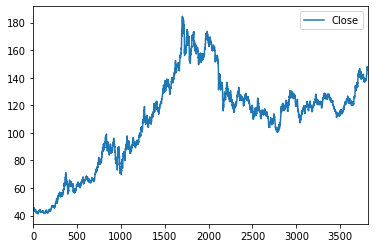

In [12]:
plt.figure(); df['Close'].plot(); plt.legend(loc='best')

In [0]:
# adding lag values
def add_lag(df, cols, lag):
    """
    add lag values up to lag
    """
    for c in cols:
        for i in range(1,lag+1): # 1 to lag value
            df[f'{c}_lag_{i}'] = df[c].shift(i)

    return df

In [7]:
df = add_lag(df, ['Open', 'High', 'Low', 'Close', 'Volume'], 7)
df.head(5).T

,0,1,2,3,4
Date,2004-11-18,2004-11-19,2004-11-22,2004-11-23,2004-11-24
Open,44.43,44.49,44.75,44.88,44.93
High,44.49,44.92,44.97,44.92,45.05
Low,44.07,44.47,44.74,44.72,44.79
Close,44.38,44.78,44.95,44.75,45.05
Adj Close,44.38,44.78,44.95,44.75,45.05
Volume,5992000,11655300,11996000,3169200,6105100
target,44.78,44.95,44.75,45.05,45.29
Open_lag_1,NaN,44.43,44.49,44.75,44.88
Open_lag_2,NaN,NaN,44.43,44.49,44.75


In [8]:
# adding cyclic datepart
add_cyclic_datepart(df, 'Date', add_linear = True)

df.head(5).T

,0,1,2,3,4
Open,4.443000e+01,4.449000e+01,4.475000e+01,4.488000e+01,4.493000e+01
High,4.449000e+01,4.492000e+01,4.497000e+01,4.492000e+01,4.505000e+01
Low,4.407000e+01,4.447000e+01,4.474000e+01,4.472000e+01,4.479000e+01
Close,4.438000e+01,4.478000e+01,4.495000e+01,4.475000e+01,4.505000e+01
Adj Close,4.438000e+01,4.478000e+01,4.495000e+01,4.475000e+01,4.505000e+01
Volume,5.992000e+06,1.165530e+07,1.199600e+07,3.169200e+06,6.105100e+06
target,4.478000e+01,4.495000e+01,4.475000e+01,4.505000e+01,4.529000e+01
Open_lag_1,NaN,4.443000e+01,4.449000e+01,4.475000e+01,4.488000e+01
Open_lag_2,NaN,NaN,4.443000e+01,4.449000e+01,4.475000e+01
Open_lag_3,NaN,NaN,NaN,4.443000e+01,4.449000e+01


<Figure size 432x288 with 0 Axes>

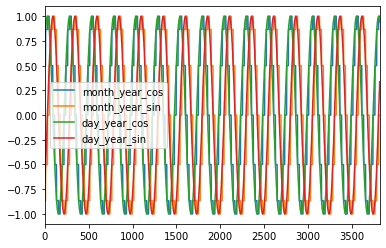

In [9]:
df_trig = df[['month_year_cos', 'month_year_sin', 'day_year_cos', 'day_year_sin']]

plt.figure(); df_trig.plot(); plt.legend(loc='best')

In [0]:
# convert ints to floats
# df = df.apply(pd.to_numeric)

In [0]:
# df.head(5).T

## Train/Val/Test split

In [0]:
# splitting based on proportion of total time

val = 0.3
val_starting_pt = int(len(df)*val)
slice_point = int(len(df) - val_starting_pt)

test = 0.1
test_starting_pt = int(len(df)*test)
test_slice_point = int(len(df) - test_starting_pt)

train_df = df[:slice_point]
val_df = df[slice_point:test_slice_point]
test_df = df[test_slice_point:]

assert len(df)==len(train_df)+len(val_df)+len(test_df), "Length of train/val/test split doesn't add up"

In [11]:
val_idx = range(slice_point,test_slice_point)

print(range(slice_point,test_slice_point))

range(2673, 3437)


In [20]:
train_df.head(5)

,Open,High,Low,Close,Adj Close,Volume,target,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,...,Open_lag_5,Open_lag_6,Open_lag_7,High_lag_1,High_lag_2,High_lag_3,High_lag_4,High_lag_5,High_lag_6,High_lag_7,Low_lag_1,Low_lag_2,Low_lag_3,Low_lag_4,Low_lag_5,Low_lag_6,Low_lag_7,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5,Close_lag_6,Close_lag_7,Volume_lag_1,Volume_lag_2,Volume_lag_3,Volume_lag_4,Volume_lag_5,Volume_lag_6,Volume_lag_7,weekday_cos,weekday_sin,day_month_cos,day_month_sin,month_year_cos,month_year_sin,day_year_cos,day_year_sin,year_lin
0,44.430000,44.490002,44.070000,44.380001,44.380001,5992000,44.779999,2.853320e+06,5992000,0.476188,NaN,NaN,NaN,-3.569009e+06,1000.00000,0.0,44.380001,44.380001,44.380001,0.000000,0.0,0.0,44.313334,44.313334,43.893332,0.0,0.0,44.380001,44.380001,1.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.900969,0.433884,-0.913545,-0.406737,0.5,-0.866025,0.728028,-0.685548,2004.879781
1,44.490002,44.919998,44.470001,44.779999,44.779999,11655300,44.950001,7.256437e+06,17647300,0.411192,NaN,1.602259,1.602259,-3.461060e+06,1000.00000,0.0,44.580000,44.979998,44.180002,0.799996,0.0,0.0,44.518333,44.518333,44.083334,0.0,0.0,44.380001,44.779999,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,44.490002,NaN,NaN,NaN,NaN,NaN,NaN,44.070000,NaN,NaN,NaN,NaN,NaN,NaN,44.380001,NaN,NaN,NaN,NaN,NaN,NaN,5992000.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.900969,-0.433884,-0.809017,-0.587785,0.5,-0.866025,0.739689,-0.672949,2004.882514
2,44.750000,44.970001,44.740002,44.950001,44.950001,11996000,44.750000,1.716617e+07,29643300,0.579091,NaN,0.306771,0.954515,1.505909e+05,1000.00000,0.0,44.703334,45.181199,44.225468,0.955730,0.0,0.0,44.641112,44.641112,44.274446,0.0,0.0,44.380001,44.950001,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,44.919998,44.490002,NaN,NaN,NaN,NaN,NaN,44.470001,44.070000,NaN,NaN,NaN,NaN,NaN,44.779999,44.380001,NaN,NaN,NaN,NaN,NaN,11655300.0,5992000.0,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,-0.309017,-0.951057,0.5,-0.866025,0.773351,-0.633978,2004.890710
3,44.880001,44.919998,44.720001,44.750000,44.750000,3169200,45.049999,1.494771e+07,26474100,0.455549,NaN,-0.220885,0.562715,3.144033e+04,995.55059,0.0,44.715000,45.130812,44.299188,0.831624,0.0,0.0,44.680000,44.680000,44.355002,0.0,0.0,44.380001,44.950001,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,44.970001,44.919998,44.490002,NaN,NaN,NaN,NaN,44.740002,44.470001,44.070000,NaN,NaN,NaN,NaN,44.950001,44.779999,44.380001,NaN,NaN,NaN,NaN,11996000.0,11655300.0,5992000.0,NaN,NaN,NaN,NaN,0.623490,0.781831,-0.104528,-0.994522,0.5,-0.866025,0.784120,-0.620609,2004.893443
4,44.930000,45.049999,44.790001,45.049999,45.049999,6105100,45.290001,2.105281e+07,32579200,0.540959,NaN,0.425872,0.528504,2.682684e+04,995.55059,0.0,44.782000,45.240414,44.323586,0.916828,0.0,0.0,44.736667,44.736667,44.424668,1.0,0.0,44.380001,45.049999,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,44.919998,44.970001,44.919998,44.490002,NaN,NaN,NaN,44.720001,44.740002,44.470001,44.07,NaN,NaN,NaN,44.750000,44.950001,44.779999,44.380001,NaN,NaN,NaN,3169200.0,11996000.0,11655300.0,5992000.0,NaN,NaN,NaN,-0.222521,0.974928,0.104528,-0.994522,0.5,-0.866025,0.794658,-0.607058,2004.896175


## Feature Engineering on train_df

In [0]:
cont_names = df.columns.tolist() # all columns are continous atm
cat_names=[] # no categorical variables 

In [22]:
"""
fill_strategy can be
FillStrategy.CONSTANT: replace with fill_val
FillStrategy.COMMON: replace with most common value
FillStrategy.MEDIAN: replace with median value
"""

tfm_fillna = FillMissing(cat_names, cont_names, fill_strategy=FillStrategy.CONSTANT, fill_val= -1)
tfm_fillna(train_df)
tfm_fillna(val_df, test=True)
tfm_fillna(test_df, test=True)

# train_df.head()

/usr/local/lib/python3.6/dist-packages/fastai/tabular/transform.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name+'_na'] = pd.isnull(df[name])
/usr/local/lib/python3.6/dist-packages/fastai/tabular/transform.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = df[name].fillna(filler)
/usr/local/lib/python3.6/dist-packages/fastai/tabular/transform.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [23]:
norm = Normalize(cat_names, cont_names)
norm.apply_train(train_df)
norm.apply_test(val_df)
norm.apply_test(test_df)

# train_df.head(5)
# val_df.tail(5)

/usr/local/lib/python3.6/dist-packages/fastai/tabular/transform.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n] = (df[n]-self.means[n]) / (1e-7 + self.stds[n])
/usr/local/lib/python3.6/dist-packages/fastai/tabular/transform.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n] = (df[n]-self.means[n]) / (1e-7 + self.stds[n])


In [24]:
# train_df.head(5)
# val_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume,target,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,...,momentum_tsi_na,momentum_uo_na,momentum_kama_na,momentum_roc_na,others_dlr_na,Open_lag_1_na,Open_lag_2_na,Open_lag_3_na,Open_lag_4_na,Open_lag_5_na,Open_lag_6_na,Open_lag_7_na,High_lag_1_na,High_lag_2_na,High_lag_3_na,High_lag_4_na,High_lag_5_na,High_lag_6_na,High_lag_7_na,Low_lag_1_na,Low_lag_2_na,Low_lag_3_na,Low_lag_4_na,Low_lag_5_na,Low_lag_6_na,Low_lag_7_na,Close_lag_1_na,Close_lag_2_na,Close_lag_3_na,Close_lag_4_na,Close_lag_5_na,Close_lag_6_na,Close_lag_7_na,Volume_lag_1_na,Volume_lag_2_na,Volume_lag_3_na,Volume_lag_4_na,Volume_lag_5_na,Volume_lag_6_na,Volume_lag_7_na
0,-1.567070,-1.574787,-1.566849,-1.568499,-1.568499,-0.523353,-1.559457,-1.338925,-1.560875,2.837604,0.08974,-0.058294,-0.216183,-7.022151,-1.201046,-2.057443,-1.558719,-1.608893,-1.499461,-1.551233,-0.264631,-0.231488,-1.565512,-1.565512,-1.557501,-0.705784,-0.548863,-1.510371,-1.604858,2.243206,3.266265,-0.836744,-0.896346,-2.097111,-2.710441,-2.662053,-2.68653,-3.529908,-3.169716,-8.983372,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,-1.565509,-1.563644,-1.556391,-1.558091,-1.558091,0.180695,-1.555031,-1.330969,-1.527248,2.404599,0.08974,0.098246,0.358571,-6.808963,-1.201046,-2.057443,-1.553526,-1.593832,-1.504819,-1.398364,-0.264631,-0.231488,-1.560182,-1.560182,-1.552517,-0.705784,-0.548863,-1.510371,-1.594754,2.243206,-0.306045,-0.836744,-0.896346,-2.097111,-2.710441,-2.662053,-2.68653,-3.529908,-3.169716,-8.983372,...,False,True,True,True,False,False,True,True,True,True,True,True,False,True,True,True,True,True,True,False,True,True,True,True,True,True,False,True,True,True,True,True,True,False,True,True,True,True,True,True
2,-1.558744,-1.562348,-1.549332,-1.553667,-1.553667,0.223050,-1.560238,-1.313062,-1.492639,3.523148,0.08974,0.020315,0.215505,0.323695,-1.201046,-2.057443,-1.550324,-1.588782,-1.503601,-1.368605,-0.264631,-0.231488,-1.556989,-1.556989,-1.547504,-0.705784,-0.548863,-1.510371,-1.590460,2.243206,-0.306045,-0.836744,-0.896346,-2.097111,-2.710441,-2.662053,-2.68653,-3.529908,-3.169716,-8.983372,...,False,True,True,True,False,False,False,True,True,True,True,True,False,False,True,True,True,True,True,False,False,True,True,True,True,True,False,False,True,True,True,True,True,False,False,True,True,True,True,True
3,-1.555361,-1.563644,-1.549855,-1.558871,-1.558871,-0.874277,-1.552428,-1.317071,-1.501782,2.700106,0.08974,-0.011426,0.128969,0.088384,-1.205107,-2.057443,-1.550021,-1.590046,-1.501626,-1.392320,-0.264631,-0.231488,-1.555978,-1.555978,-1.545391,-0.705784,-0.548863,-1.510371,-1.590460,-0.445623,-0.306045,-0.836744,-0.896346,-2.097111,-2.710441,-2.662053,-2.68653,-3.529908,-3.169716,-8.983372,...,False,True,True,True,False,False,False,False,True,True,True,True,False,False,False,True,True,True,True,False,False,False,True,True,True,True,False,False,False,True,True,True,True,False,False,False,True,True,True,True
4,-1.554060,-1.560275,-1.548025,-1.551065,-1.551065,-0.509293,-1.546180,-1.306040,-1.484168,3.269108,0.08974,0.027480,0.121413,0.079273,-1.205107,-2.057443,-1.548282,-1.587295,-1.500973,-1.376039,-0.264631,-0.231488,-1.554505,-1.554505,-1.543563,1.416332,-0.548863,-1.510371,-1.587935,2.243206,-0.306045,-0.836744,-0.896346,-2.097111,-2.710441,-2.662053,-2.68653,-3.529908,-3.169716,-8.983372,...,False,True,True,True,False,False,False,False,False,True,True,True,False,

## Start Modelling

In [0]:
path = './'

In [0]:
#combine train and val together

train_val_df = pd.concat([train_df, val_df])

checking if concat correctly

In [14]:
# train_df.head(5)
val_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume,target,Open_lag_1,Open_lag_2,Open_lag_3,Open_lag_4,Open_lag_5,Open_lag_6,Open_lag_7,High_lag_1,High_lag_2,High_lag_3,High_lag_4,High_lag_5,High_lag_6,High_lag_7,Low_lag_1,Low_lag_2,Low_lag_3,Low_lag_4,Low_lag_5,Low_lag_6,Low_lag_7,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5,Close_lag_6,Close_lag_7,Volume_lag_1,Volume_lag_2,Volume_lag_3,Volume_lag_4,Volume_lag_5,Volume_lag_6,Volume_lag_7,weekday_cos,weekday_sin,day_month_cos,day_month_sin,month_year_cos,month_year_sin,day_year_cos,day_year_sin,year_lin
3432,118.889999,119.000000,118.610001,118.930000,118.930000,3754800,117.639999,119.650002,118.970001,118.919998,118.410004,118.180000,118.430000,118.589996,119.730003,119.029999,119.330002,119.080002,118.209999,118.940002,118.669998,119.139999,118.730003,118.769997,118.379997,117.400002,118.260002,118.010002,119.150002,118.860001,119.050003,118.650002,117.459999,118.650002,118.220001,4074900.0,2946900.0,4951900.0,8901000.0,12021900.0,8002800.0,7760500.0,0.623490,0.781831,-0.250653,0.968077,-1.0,1.224647e-16,-0.991677,-0.128748,2018.520548
3433,118.449997,118.529999,117.620003,117.639999,117.639999,6974500,118.129997,118.889999,119.650002,118.970001,118.919998,118.410004,118.180000,118.430000,119.000000,119.730003,119.029999,119.330002,119.080002,118.209999,118.940002,118.610001,119.139999,118.730003,118.769997,118.379997,117.400002,118.260002,118.930000,119.150002,118.860001,119.050003,118.650002,117.459999,118.650002,3754800.0,4074900.0,2946900.0,4951900.0,8901000.0,12021900.0,8002800.0,-0.222521,0.974928,-0.440394,0.897805,-1.0,1.224647e-16,-0.989314,-0.145799,2018.523288
3434,118.000000,118.260002,117.940002,118.129997,118.129997,4585300,117.610001,118.449997,118.889999,119.650002,118.970001,118.919998,118.410004,118.180000,118.529999,119.000000,119.730003,119.029999,119.330002,119.080002,118.209999,117.620003,118.610001,119.139999,118.730003,118.769997,118.379997,117.400002,117.639999,118.930000,119.150002,118.860001,119.050003,118.650002,117.459999,6974500.0,3754800.0,4074900.0,2946900.0,4951900.0,8901000.0,12021900.0,-0.900969,0.433884,-0.612106,0.790776,-1.0,1.224647e-16,-0.986658,-0.162807,2018.526027
3435,117.620003,117.750000,117.449997,117.610001,117.610001,5444300,117.550003,118.000000,118.449997,118.889999,119.650002,118.970001,118.919998,118.410004,118.260002,118.529999,119.000000,119.730003,119.029999,119.330002,119.080002,117.940002,117.620003,118.610001,119.139999,118.730003,118.769997,118.379997,118.129997,117.639999,118.930000,119.150002,118.860001,119.050003,118.650002,4585300.0,6974500.0,3754800.0,4074900.0,2946900.0,4951900.0,8901000.0,-0.900969,-0.433884,-0.758758,0.651372,-1.0,1.224647e-16,-0.983709,-0.179767,2018.528767
3436,117.510002,117.629997,117.279999,117.550003,117.550003,3670700,116.279999,117.620003,118.000000,118.449997,118.889999,119.650002,118.970001,118.919998,117.750000,118.260002,118.529999,119.000000,119.730003,119.029999,119.330002,117.449997,117.940002,117.620003,118.610001,119.139999,118.730003,118.769997,117.610001,118.129997,117.639999,118.930000,119.150002,118.860001,119.050003,5444300.0,4585300.0,6974500.0,3754800.0,4074900.0,2946900.0,4951900.0,1.000000,0.000000,-0.994869,0.101168,-1.0,1.224647e-16,-0.973118,-0.230306,2018.536986


In [37]:
# train_val_df.head(5)
train_val_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume,target,Open_lag_1,Open_lag_2,Open_lag_3,Open_lag_4,Open_lag_5,Open_lag_6,Open_lag_7,High_lag_1,High_lag_2,High_lag_3,High_lag_4,High_lag_5,High_lag_6,High_lag_7,Low_lag_1,Low_lag_2,Low_lag_3,Low_lag_4,Low_lag_5,Low_lag_6,Low_lag_7,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5,Close_lag_6,Close_lag_7,Volume_lag_1,Volume_lag_2,Volume_lag_3,Volume_lag_4,Volume_lag_5,Volume_lag_6,Volume_lag_7,weekday_cos,weekday_sin,day_month_cos,day_month_sin,month_year_cos,month_year_sin,day_year_cos,day_year_sin,year_lin
3432,118.889999,119.000000,118.610001,118.930000,118.930000,3754800,117.639999,119.650002,118.970001,118.919998,118.410004,118.180000,118.430000,118.589996,119.730003,119.029999,119.330002,119.080002,118.209999,118.940002,118.669998,119.139999,118.730003,118.769997,118.379997,117.400002,118.260002,118.010002,119.150002,118.860001,119.050003,118.650002,117.459999,118.650002,118.220001,4074900.0,2946900.0,4951900.0,8901000.0,12021900.0,8002800.0,7760500.0,0.623490,0.781831,-0.250653,0.968077,-1.0,1.224647e-16,-0.991677,-0.128748,2018.520548
3433,118.449997,118.529999,117.620003,117.639999,117.639999,6974500,118.129997,118.889999,119.650002,118.970001,118.919998,118.410004,118.180000,118.430000,119.000000,119.730003,119.029999,119.330002,119.080002,118.209999,118.940002,118.610001,119.139999,118.730003,118.769997,118.379997,117.400002,118.260002,118.930000,119.150002,118.860001,119.050003,118.650002,117.459999,118.650002,3754800.0,4074900.0,2946900.0,4951900.0,8901000.0,12021900.0,8002800.0,-0.222521,0.974928,-0.440394,0.897805,-1.0,1.224647e-16,-0.989314,-0.145799,2018.523288
3434,118.000000,118.260002,117.940002,118.129997,118.129997,4585300,117.610001,118.449997,118.889999,119.650002,118.970001,118.919998,118.410004,118.180000,118.529999,119.000000,119.730003,119.029999,119.330002,119.080002,118.209999,117.620003,118.610001,119.139999,118.730003,118.769997,118.379997,117.400002,117.639999,118.930000,119.150002,118.860001,119.050003,118.650002,117.459999,6974500.0,3754800.0,4074900.0,2946900.0,4951900.0,8901000.0,12021900.0,-0.900969,0.433884,-0.612106,0.790776,-1.0,1.224647e-16,-0.986658,-0.162807,2018.526027
3435,117.620003,117.750000,117.449997,117.610001,117.610001,5444300,117.550003,118.000000,118.449997,118.889999,119.650002,118.970001,118.919998,118.410004,118.260002,118.529999,119.000000,119.730003,119.029999,119.330002,119.080002,117.940002,117.620003,118.610001,119.139999,118.730003,118.769997,118.379997,118.129997,117.639999,118.930000,119.150002,118.860001,119.050003,118.650002,4585300.0,6974500.0,3754800.0,4074900.0,2946900.0,4951900.0,8901000.0,-0.900969,-0.433884,-0.758758,0.651372,-1.0,1.224647e-16,-0.983709,-0.179767,2018.528767
3436,117.510002,117.629997,117.279999,117.550003,117.550003,3670700,116.279999,117.620003,118.000000,118.449997,118.889999,119.650002,118.970001,118.919998,117.750000,118.260002,118.529999,119.000000,119.730003,119.029999,119.330002,117.449997,117.940002,117.620003,118.610001,119.139999,118.730003,118.769997,117.610001,118.129997,117.639999,118.930000,119.150002,118.860001,119.050003,5444300.0,4585300.0,6974500.0,3754800.0,4074900.0,2946900.0,4951900.0,1.000000,0.000000,-0.994869,0.101168,-1.0,1.224647e-16,-0.973118,-0.230306,2018.536986


In [0]:
# df = df[['Open', 'High', 'Low', 'Close', 'target']]

In [0]:
cont_names = df.columns.tolist() # all columns are continous atm
# cont_names = ['Open', 'High', 'Low', 'Close']
cat_names=None # no categorical variables 

tfm_fillna = FillMissing(cat_names, cont_names, fill_strategy=FillStrategy.CONSTANT, fill_val= -1)

bs = 64

# train_val_df

# data = (TabularList.from_df(df, path=path, procs=[FillMissing, Normalize],)
#                 .split_by_idx(val_idx)
#                 .label_from_df(cols='target', label_cls=FloatList, log=True) # using logged target values
#                 .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_names, cont_names=cont_names))
#                 .databunch(bs = bs))

data = TabularDataBunch.from_df(path, df, 'target', valid_idx=val_idx, procs=[FillMissing, Normalize], cat_names=cat_names,
                                bs = bs)
data.c=1

In [0]:
# max_log_y = np.log(np.max(train_val_df['target'])*1.2)
# y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [0]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, metrics=exp_rmspe)



In [45]:
learn.fit(10)

epoch,train_loss,valid_loss,exp_rmspe,time
0,10821.709961,10036.038086,nan,00:00
1,8102.476074,4425.194824,nan,00:00
2,3744.012207,205.201981,nan,00:00
3,1428.532593,16.629980,nan,00:00
4,569.730957,6.844679,nan,00:00
5,240.220184,8.637651,nan,00:00
6,113.515327,4.259746,nan,00:00
7,62.743404,2.955012,nan,00:00
8,42.478115,3.129956,nan,00:00
9,39.880035,2.411235,nan,00:00
